In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -qq /content/drive/MyDrive/archive.zip -d /content/input

replace /content/input/sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import numpy as np
import pandas as pd
import os
import torch.nn as nn
from tqdm import tqdm

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision import models
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# # Устанавливаем переменную окружения PYTORCH_CUDA_ALLOC_CONF
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
ls input/train/train

'Apple Braeburn'/       Cantaloupe/       Lemon/            Peach/          'Potato Red'/
'Apple Granny Smith'/   Cherry/           Limes/            Pear/            Raspberry/
 Apricot/               Clementine/       Mango/           'Pepper Green'/   Strawberry/
 Avocado/               Corn/            'Onion White'/    'Pepper Red'/     Tomato/
 Banana/               'Cucumber Ripe'/   Orange/           Pineapple/       Watermelon/
 Blueberry/            'Grape Blue'/      Papaya/           Plum/
'Cactus fruit'/         Kiwi/            'Passion Fruit'/   Pomegranate/


In [5]:
transform1 = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5)
])

train_path = 'input/train/train'
# train_path = '/content/input/train/train' #if using a Colab

In [6]:
train_data1= ImageFolder(train_path,transform = transform1)
train_data2= ImageFolder(train_path,transform = transform2)
classes = train_data1.classes

train_ratio = 0.8
dataset_size = len(train_data1)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_data1, test_data = random_split(train_data1, [train_size, test_size])

train_data = torch.utils.data.ConcatDataset([train_data2, train_data1])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)

In [10]:
model = models.efficientnet_b1(weights='IMAGENET1K_V1')

# Get the number of input features for the last layer
num_ftrs = model.classifier
# print(num_ftrs)
# Replace the last fully connected layer with a new classification layer
num_classes = len(classes)  # Assuming 'classes' is a list containing class labels
model.classifier[1] = nn.Linear(1280, num_classes, bias=True)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =  0.001)

In [11]:
train_accuracies = []
test_accuracies = []
num_epochs = 4
for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / total_train

    train_accuracies.append(train_accuracy)
    # Evaluation (Test)
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate test accuracy and loss
    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test

    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc:{test_accuracy:.4f}")

100%|██████████| 475/475 [04:34<00:00,  1.73it/s]


Epoch 1/4 - Train Loss: 3.1563 - Train Acc: 0.2911 - Test Loss: 2.7164 - Test Acc:0.6408


100%|██████████| 475/475 [04:36<00:00,  1.72it/s]


Epoch 2/4 - Train Loss: 2.3852 - Train Acc: 0.7564 - Test Loss: 1.9081 - Test Acc:0.9158


100%|██████████| 475/475 [04:36<00:00,  1.72it/s]


Epoch 3/4 - Train Loss: 1.6306 - Train Acc: 0.9336 - Test Loss: 1.2216 - Test Acc:0.9786


100%|██████████| 475/475 [04:36<00:00,  1.72it/s]


Epoch 4/4 - Train Loss: 1.0297 - Train Acc: 0.9756 - Test Loss: 0.7453 - Test Acc:0.9908


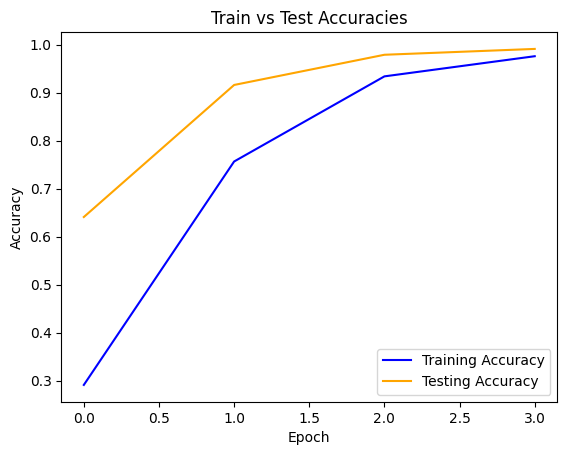

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x = range(4), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(4), y = test_accuracies, color = "orange", label = "Testing Accuracy")
plt.title("Train vs Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [15]:
# use to save to Google Drive
torch.save(model.state_dict(), '/content/drive/MyDrive/model.pth')